In [12]:
import numpy as np
import os
import glob
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
from subprocess import call

In [13]:
dir_pre = "/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.7.2/m6A/nano_merge"

output_all_path = f"{dir_pre}_m6A_SNP.csv"

In [15]:
files = glob.glob(f'{dir_pre}_haplotype_chr*_tmp.csv')
dfs = [pd.read_csv(file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by=['chrom', 'm6A_pos_1base', 'snp_pos_1base'])
df = df.reset_index(drop=True)

In [16]:
print("pvalue小于0.05的个数：", len(df[df['p_value']<0.05]))
print("fdr小于0.1的个数：", len(df[df['FDR']<0.1]))
print("m6Aqtl同时也是m6A的个数： ", len(df[(df['ism6A?']=="Yes")&(df['p_value']<0.05)]))
df.to_csv(output_all_path, index=False)
call(f'rm {dir_pre}_haplotype_chr*_tmp.csv', shell=True)

pvalue小于0.05的个数： 8881
fdr小于0.1的个数： 718
m6Aqtl同时也是m6A的个数：  13


rm: cannot remove '/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.7.2/m6A/nano_merge_haplotype_chr*_tmp.csv': No such file or directory


1

Genomic inflation factor (λGC): 0.98


/tmp/ipykernel_5772/3248741775.py:6: RuntimeWarning: divide by zero encountered in log10
  observed = -np.log10(np.sort(p_values))


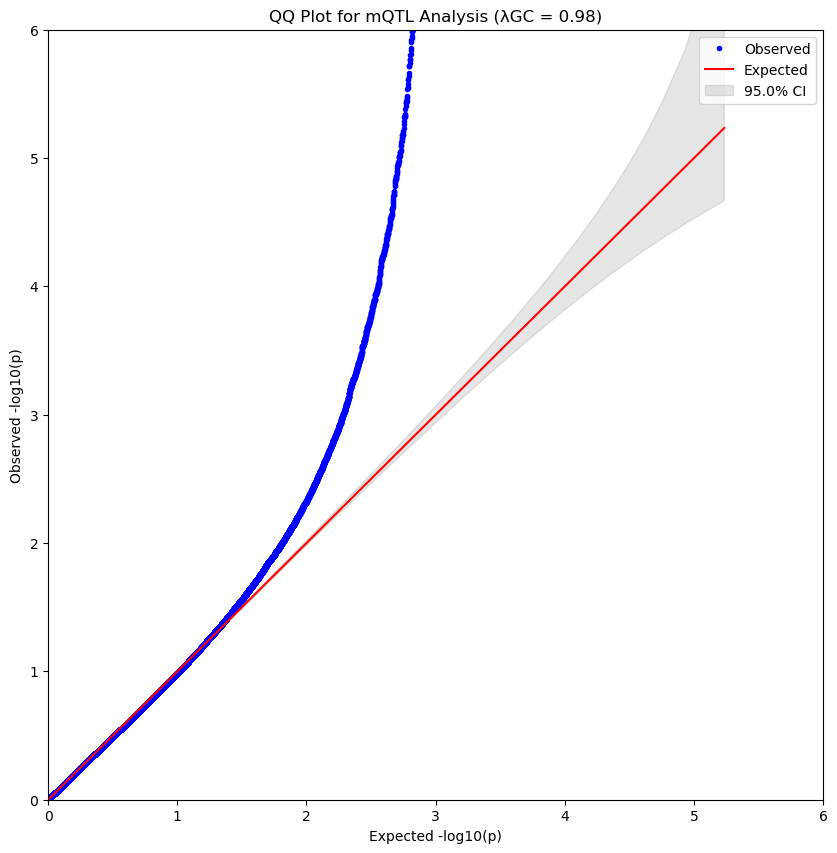

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_qq(p_values, title, ci=0.95):
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.linspace(1/len(p_values), 1, len(p_values)))
    
    plt.figure(figsize=(10, 10))
    plt.plot(expected, observed, 'b.', label='Observed')
    plt.plot([0, max(expected)], [0, max(expected)], 'r-', label='Expected')
    
    # 添加置信区间
    ci_lower = -np.log10(stats.beta.ppf((1-ci)/2, np.arange(1, len(p_values)+1), np.arange(len(p_values), 0, -1)))
    ci_upper = -np.log10(stats.beta.ppf(1-(1-ci)/2, np.arange(1, len(p_values)+1), np.arange(len(p_values), 0, -1)))
    plt.fill_between(expected, ci_lower, ci_upper, color='gray', alpha=0.2, label=f'{ci*100}% CI')
    
    plt.xlabel('Expected -log10(p)')
    plt.ylabel('Observed -log10(p)')
    plt.title(title)
    plt.legend()
    ax = plt.gca()
    ax.set_xlim([0, 6])
    ax.set_ylim([0, 6])
    ax.set_xticks(np.arange(0, 7, 1))
    ax.set_yticks(np.arange(0, 7, 1))
    plt.show()

# 计算基因组通胀因子
def genomic_inflation_factor(p_values):
    chi2_obs = stats.chi2.ppf(1 - p_values, df=1)
    return np.median(chi2_obs) / stats.chi2.ppf(0.5, 1)

# 使用示例
col = 'p_value'
d = df.dropna(subset=[col])
lambda_gc = genomic_inflation_factor(d[col])
print(f"Genomic inflation factor (λGC): {lambda_gc:.2f}")

plot_qq(d[col], f'QQ Plot for mQTL Analysis (λGC = {lambda_gc:.2f})')